In [1]:
import os
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader
import torch.distributions as dists
from torchvision import datasets, transforms
from sklearn.manifold import TSNE
import pandas as pd
import math
import random
import matplotlib.pyplot as plt


In [2]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
setup_seed(1142)

In [3]:
class CNN_VectorQuantizer(nn.Module):
    """
    VQ-VAE layer: Input any tensor to be quantized. 
    Args:
        embedding_dim (int): the dimensionality of the tensors in the
          quantized space. Inputs to the modules must be in this format as well.
        num_embeddings (int): the number of vectors in the quantized space.
        commitment_cost (float): scalar which controls the weighting of the loss terms (see
          equation 4 in the paper - this variable is Beta).
    """
    def __init__(self, embedding_dim, num_embeddings, commitment_cost):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.commitment_cost = commitment_cost
        
        # initialize embeddings
        self.embeddings = nn.Embedding(self.num_embeddings, self.embedding_dim)
        
    def forward(self, x):
        # [B, C, H, W] -> [B, H, W, C]
        x = x.permute(0, 2, 3, 1).contiguous()
        # [B, H, W, C] -> [BHW, C]
        flat_x = x.reshape(-1, self.embedding_dim)
        
        encoding_indices = self.get_code_indices(flat_x)
        quantized = self.quantize(encoding_indices)
        quantized = quantized.view_as(x) # [B, H, W, C]
        
        if not self.training:
            quantized = quantized.permute(0, 3, 1, 2).contiguous()
            return quantized,encoding_indices
        
        # embedding loss: move the embeddings towards the encoder's output
        q_latent_loss = F.mse_loss(quantized, x.detach())
        # commitment loss
        e_latent_loss = F.mse_loss(x, quantized.detach())
        loss = q_latent_loss + self.commitment_cost * e_latent_loss

        # Straight Through Estimator
        quantized = x + (quantized - x).detach()
        
        quantized = quantized.permute(0, 3, 1, 2).contiguous()
        return quantized, loss
    
    def get_code_indices(self, flat_x):
        # compute L2 distance
        distances = (
            torch.sum(flat_x ** 2, dim=1, keepdim=True) +
            torch.sum(self.embeddings.weight ** 2, dim=1) -
            2. * torch.matmul(flat_x, self.embeddings.weight.t())
        ) # [N, M]
        encoding_indices = torch.argmin(distances, dim=1) # [N,]
        return encoding_indices
    
    def quantize(self, encoding_indices):
        """Returns embedding tensor for a batch of indices."""
        return self.embeddings(encoding_indices)  

class CNN_Encoder(nn.Module):
    """Encoder of VQ-VAE"""
    
    def __init__(self, in_dim=3, latent_dim=16):
        super().__init__()
        self.in_dim = in_dim
        self.latent_dim = latent_dim
        
        self.convs = nn.Sequential(
            nn.Conv2d(in_dim, 32, 3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, latent_dim, 1),
        )
        
    def forward(self, x):
        return self.convs(x)
    

class CNN_Decoder(nn.Module):
    """Decoder of VQ-VAE"""
    
    def __init__(self, out_dim=1, latent_dim=16):
        super().__init__()
        self.out_dim = out_dim
        self.latent_dim = latent_dim
        
        self.convs = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, out_dim, 3, padding=1),
        )
        
    def forward(self, x):
        return self.convs(x)

class VQVAE(nn.Module):
    """VQ-VAE"""
    
    def __init__(self, in_dim, embedding_dim, num_embeddings, data_variance, 
                 commitment_cost=0.25):
        super().__init__()
        self.in_dim = in_dim
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.data_variance = data_variance
        
        self.encoder = CNN_Encoder(in_dim, embedding_dim)
        self.vq_layer = CNN_VectorQuantizer(embedding_dim, num_embeddings, commitment_cost)
        self.decoder = CNN_Decoder(in_dim, embedding_dim)
        
    def forward(self, x):
        z = self.encoder(x)
        if not self.training:
            e,enco = self.vq_layer(z)
            x_recon = self.decoder(e)
            return e, x_recon,enco
        
        e, e_q_loss = self.vq_layer(z)
        x_recon = self.decoder(e)
        
        recon_loss = F.mse_loss(x_recon, x) / self.data_variance
        
        return e_q_loss , recon_loss ,F.mse_loss(x_recon, x)   

In [4]:
epochs=10
batch_size = 256
embedding_dim = 16
num_embeddings = 128

In [5]:
print('Load DataSet....')
transform=transforms.Compose([
    transforms.ToTensor(),
])

dataset1 = datasets.FashionMNIST('/data/liumingxuan/SNN-VAE-DMSVDD/datasets/Datasets', train=True, download=True,
                        transform=transform)
dataset2 = datasets.FashionMNIST('/data/liumingxuan/SNN-VAE-DMSVDD/datasets/Datasets', train=False,
                        transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=batch_size)
print('done!')

Load DataSet....
done!


In [6]:
print('prepare vq-vae....')
train_images = []
for images, labels in train_loader:
    train_images.append(images)
train_images = torch.cat(train_images, dim=0)
train_data_variance = torch.var(train_images)
model = VQVAE(1, embedding_dim, num_embeddings, train_data_variance)
model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
for epoch in range(epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images - 0.5 # normalize to [-0.5, 0.5]
        images = images.cuda()
        loss_eq,loss_rec,real_loss_rec = model(images)
        loss = loss_eq+loss_rec
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch {} Loss {:.3f} Loss_eq {:.3f} Loss_rec {:.3f}".format(epoch, loss, loss_eq, real_loss_rec))

prepare vq-vae....
Epoch 0 Loss 0.498 Loss_eq 0.335 Loss_rec 0.020
Epoch 1 Loss 0.401 Loss_eq 0.272 Loss_rec 0.016
Epoch 2 Loss 0.353 Loss_eq 0.244 Loss_rec 0.014
Epoch 3 Loss 0.310 Loss_eq 0.216 Loss_rec 0.012
Epoch 4 Loss 0.284 Loss_eq 0.196 Loss_rec 0.011
Epoch 5 Loss 0.262 Loss_eq 0.187 Loss_rec 0.009
Epoch 6 Loss 0.253 Loss_eq 0.180 Loss_rec 0.009
Epoch 7 Loss 0.214 Loss_eq 0.151 Loss_rec 0.008
Epoch 8 Loss 0.241 Loss_eq 0.172 Loss_rec 0.009
Epoch 9 Loss 0.220 Loss_eq 0.158 Loss_rec 0.008


test vq-vae....


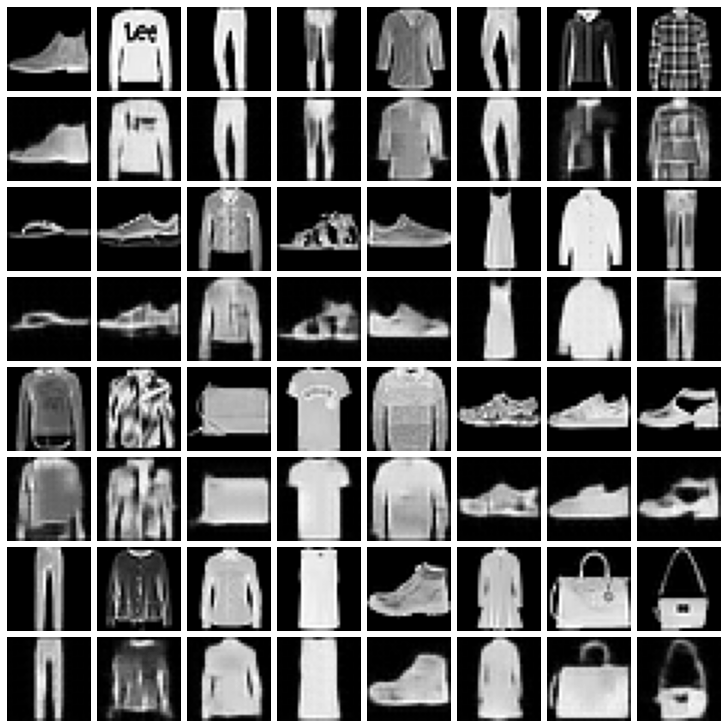

In [7]:
print('test vq-vae....')
# reconstructe images

test_loader_iter = iter(test_loader)
images, labels = next(test_loader_iter)

n_samples = 32
images = images[:n_samples]

model.eval()

norm_images = (images - 0.5).cuda()
with torch.inference_mode():
    e, recon_images,_ = model(norm_images)

recon_images = np.array(np.clip((recon_images + 0.5).cpu().numpy(), 0., 1.) * 255, dtype=np.uint8)
ori_images = np.array(images.numpy() * 255, dtype=np.uint8)

recon_images = recon_images.reshape(4, 8, 28, 28)
ori_images = ori_images.reshape(4, 8, 28, 28)

fig = plt.figure(figsize=(10, 10), constrained_layout=True)
gs = fig.add_gridspec(8, 8)
for n_row in range(4):
    for n_col in range(8):
        f_ax = fig.add_subplot(gs[n_row * 2, n_col])
        f_ax.imshow(ori_images[n_row, n_col], cmap="gray")
        f_ax.axis("off")
        f_ax = fig.add_subplot(gs[n_row * 2 + 1, n_col])
        f_ax.imshow(recon_images[n_row, n_col], cmap="gray")
        f_ax.axis("off")

In [8]:
print('prepare data for train diffusion...')
train_indices = []
for images, labels in train_loader:
    images = images - 0.5 # normalize to [-0.5, 0.5]
    images = images.cuda()
    with torch.inference_mode():
        _,_,encoding_indices = model(images) # [B, C, H, W, T]
        train_indices.append(encoding_indices.reshape(images.shape[0],7,7).cpu())
print(len(train_indices))

prepare data for train diffusion...
235


In [9]:
print((train_indices[0][100]))
mask_id, index = torch.mode(train_indices[0][100])
mask_id = mask_id[0]
mask_id = 0
print("mask_id =" ,mask_id)

tensor([[ 97,  88,  48,  48,  72, 112,  97],
        [ 97,  35, 100, 100, 100, 100,  86],
        [ 97,  50, 100, 100, 100, 100,  46],
        [ 97,   7, 100, 100, 100, 100,  14],
        [ 97,  72,  48, 100, 100,  40,  14],
        [ 97,   4,  73, 100, 100,  94,  14],
        [ 97, 115,   1, 124, 124, 115, 115]])
mask_id = 0


In [10]:
print('data for train diffusion is ready!')

data for train diffusion is ready!


In [11]:
class AbsorbingDiffusion():

    # H：存放超参数
    # denoise_fn：逆扩散模型，即为一个Transformer模型
    # mask_id：决定mask掉的位置使用哪个参数
    # embedding_weight：vq_vae中embedding层内部的参数
    # aux_weight——暂时不知道
    def __init__(self, denoise_fn, mask_id):
        super().__init__()

        # 类别数量——即codebook的size数量——128
        self.num_classes = 128

        # latent的shape，7x7
        self.shape = [7,7]

        # 时间步数量
        self.num_timesteps = 256

        # mask掉的位置用什么填充
        self.mask_id = mask_id

        # 去噪模型
        self._denoise_fn = denoise_fn

        # 一次采样输出的数量
        self.n_samples = 64


    def sample_time(self, b, device):
        # 这里应该是每次训练都从各种程度的噪声中进行采样
        # 那么从1到num_timesteps之间随机整数采样b个时间步长t
        t = torch.randint(1, self.num_timesteps+1, (b,), device=device).long()

        # 将pt设置为一个全1的张量，除以num_timesteps，表示每个时间步长有相同的概率
        pt = torch.ones_like(t).float() / self.num_timesteps
        return t, pt

    # 它的作用是采样q(x_t | x_0)，即给定x_0的条件下，x_t的概率分布。x_t是加入了噪声和掩码的x_0
    def q_sample(self, x_0, t):
        # samples q(x_t | x_0)
        # randomly set token to mask with probability t/T

        # 输入是原始矩阵x_0和时间t，首先copy一下输入x_t
        x_t, x_0_ignore = x_0.clone(), x_0.clone()
        #print(x_t.shape)
        #print(t.shape)
        # 生成一个与x_t形状相同的随机张量mask，它的元素是0或1，表示是否要掩码某个位置。掩码的概率与t成正比，即t越大，掩码越多
        # 当t最大时mask取全1，这个是一个均匀扩散过程
        t_mask = t.reshape(x_0.shape[0], 1, 1,1)
        t_mask = t_mask.expand(x_0.shape[0], 1, 7, 7)
        
        mask = torch.rand_like(x_t.float()) < (t_mask.float() / self.num_timesteps)

        # 将x_t中mask为1的位置替换为self.mask_id，这是一个特殊的标识符，表示该位置被掩码了。
        x_t[mask] = self.mask_id

        # 将x_0_ignore中mask为0的位置替换为-1，这是一个忽略索引，表示该位置不参与损失计算
        x_0_ignore[torch.bitwise_not(mask)] = -1
        return x_t, x_0_ignore, mask

    # 训练损失如何得到
    # 输入编码矩阵x_0
    def _train_loss(self, x_0):

        # b-batch_size
        b, device = x_0.size(0), x_0.device
        
        # choose what time steps to compute loss at
        # 得到本次训练的时间与每个时间出现的概率，这里每个时间出现的概率相等
        t, pt = self.sample_time(b, device)

        # make x noisy and denoise
        # 输入x_0与t得到掩码噪声后的结果
        x_t, x_0_ignore, mask = self.q_sample(x_0=x_0, t=t)

        # sample p(x_0 | x_t)
        # 调用_denoise_fn函数，对x_t进行去噪，得到x_0_hat_logits，即x_0的预测概率分布
        x_0_hat_logits = self._denoise_fn(x_t, t=t)

        # Always compute ELBO for comparison purposes
        # x_0_ignore(256,1,7,7)
        # x_0_hat_logits(258,128,7,7)
        # 调用F.cross_entropy函数，使用x_0_hat_logits和x_0_ignore计算交叉熵损失，忽略索引为-1的位置，得到每个样本的损失之和cross_entropy_loss
        cross_entropy_loss = F.cross_entropy(x_0_hat_logits.reshape(b,128,49), x_0_ignore.reshape(b,49).type(torch.LongTensor).cuda(), ignore_index=-1, reduction='none').sum(1)
        
        # 计算变分下界vb_loss，即将cross_entropy_loss除以t和pt，并除以log(2)乘以x_0的元素数量。这是为了估计p(x_0)的下界。
        vb_loss = cross_entropy_loss / t
        vb_loss = vb_loss / pt
        vb_loss = vb_loss / (math.log(2) * x_0.shape[1:].numel())

        # 根据loss_type的值，选择不同的损失函数
        loss = vb_loss

        return loss.mean()

    def sample(self, temp=1.0, sample_steps=None):
        b, device = self.n_samples, 'cuda'
        x_t = torch.ones(b,1,7,7, device=device).long() * self.mask_id

        unmasked = torch.zeros_like(x_t, device=device).bool()
        
        sample_steps = list(range(1, sample_steps+1))

        for t in reversed(sample_steps):
            print(f'Sample timestep {t:4d}', end='\r')
            t = torch.full((b,), t, device=device, dtype=torch.long)

            # where to unmask
            # TODO: 随着时间步长的增长 降低已经被回复过的像素的再被回复的概率
            t_mask = t.reshape(b, 1, 1,1)
            t_mask = t_mask.expand(b, 1, 7, 7)
            #print(t_mask.shape)
            #print(x_t.shape)
            changes = torch.rand_like(x_t.float()) < 1/t_mask.float()
            changes = changes.cuda()
            #print(changes.shape)
            # don't unmask somewhere already unmasked
            changes = torch.bitwise_xor(changes, torch.bitwise_and(changes, unmasked))
            # update mask with changes
            unmasked = torch.bitwise_or(unmasked, changes)

            x_0_logits = self._denoise_fn(x_t.float(), t=t)
            #print(x_0_logits.shape)

            # scale by temperature
            x_0_logits = x_0_logits / temp
            index = torch.argmax(x_0_logits, dim=1)
            x_0_hat = index.unsqueeze(1)

            #print(x_0_hat.shape)

            x_t.long()[changes] = x_0_hat.long()[changes]

        return x_t

    def train_iter(self, x):
        loss = self._train_loss(x)
        stats = {'loss': loss}
        return stats

In [12]:
blk = lambda ic, oc: nn.Sequential(
    nn.Conv2d(ic, oc, 3, 1, 1),
    nn.BatchNorm2d(oc),
    nn.LeakyReLU(),
)

class DummyModel(nn.Module):
    """
    This should be transformer, but let's don't think about the model too much :P
    Basically, any universal R^n -> R^n model should work.
    """
    # batch_size 1 7 7 
    # batch_size  1287 7
    # batch_size 1 7 7 
    def __init__(self, n_channel: int) -> None:
        super(DummyModel, self).__init__()
        self.conv = nn.Sequential(  # with batchnorm
            blk(n_channel, 64),
            blk(64,128),
            blk(128, 256),
            blk(256, 512),
            blk(512, 256),
            blk(256, 256),
            nn.Conv2d(256, 128, 3, 1,1),
        )

    def forward(self, x, t) -> torch.Tensor:
        # Lets think about using t later. In the paper, they used Tr-like positional embeddings.
        return self.conv(x)


In [13]:
denoise_fn = DummyModel(1).cuda()
abdiff = AbsorbingDiffusion(denoise_fn, mask_id=mask_id)

Epoch 0  Loss 2.738
Epoch 1  Loss 2.636
Epoch 2  Loss 2.271
Epoch 3  Loss 2.383
Epoch 4  Loss 2.142


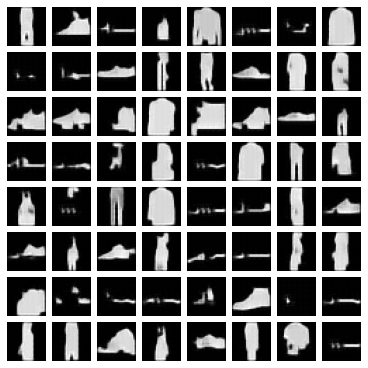

Epoch 5  Loss 2.139
Epoch 6  Loss 2.193
Epoch 7  Loss 2.173
Epoch 8  Loss 2.171
Epoch 9  Loss 2.074


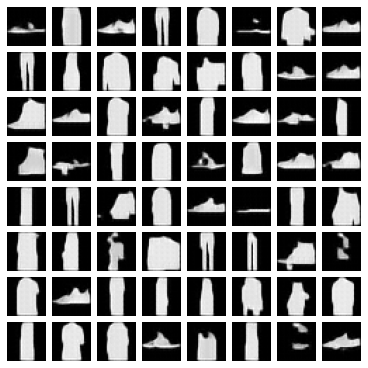

Epoch 10  Loss 2.047
Epoch 11  Loss 1.966
Epoch 12  Loss 1.930
Epoch 13  Loss 2.034
Epoch 14  Loss 2.090


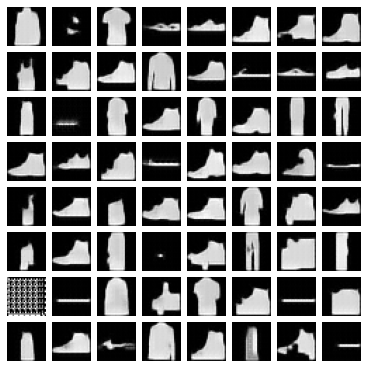

Epoch 15  Loss 1.986
Epoch 16  Loss 1.910
Epoch 17  Loss 1.957
Epoch 18  Loss 2.063
Epoch 19  Loss 1.949


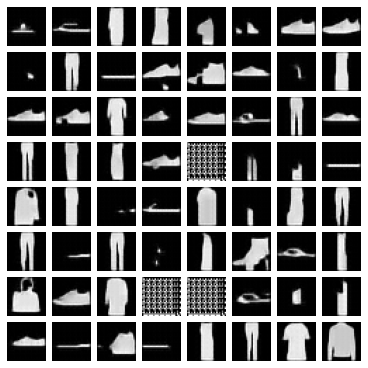

Epoch 20  Loss 2.044
Epoch 21  Loss 2.099
Epoch 22  Loss 1.806
Epoch 23  Loss 2.064
Epoch 24  Loss 1.741


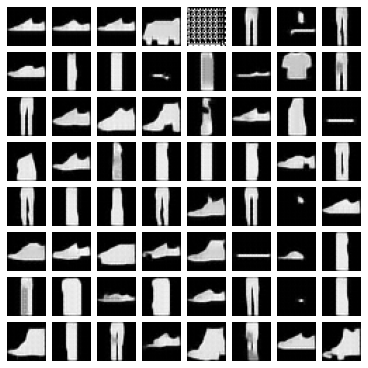

Epoch 25  Loss 1.784
Epoch 26  Loss 1.895
Epoch 27  Loss 1.932
Epoch 28  Loss 1.964
Epoch 29  Loss 1.935


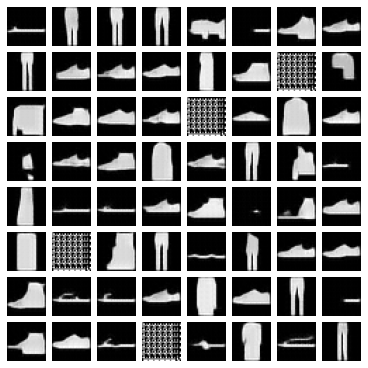

Epoch 30  Loss 1.907
Epoch 31  Loss 1.893
Epoch 32  Loss 1.835
Epoch 33  Loss 1.908
Epoch 34  Loss 1.882


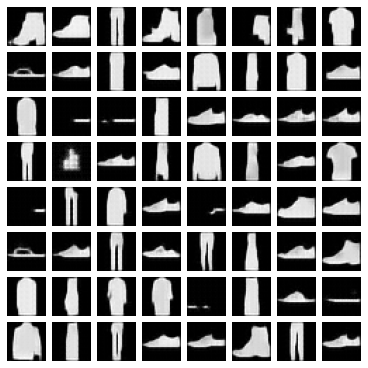

Epoch 35  Loss 1.882
Epoch 36  Loss 2.234
Epoch 37  Loss 1.731
Epoch 38  Loss 1.847
Epoch 39  Loss 1.931


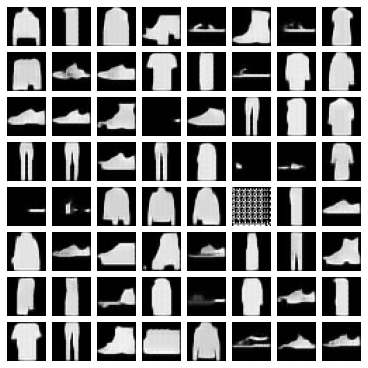

Epoch 40  Loss 1.745
Epoch 41  Loss 1.776
Epoch 42  Loss 2.729
Epoch 43  Loss 1.814
Epoch 44  Loss 1.815


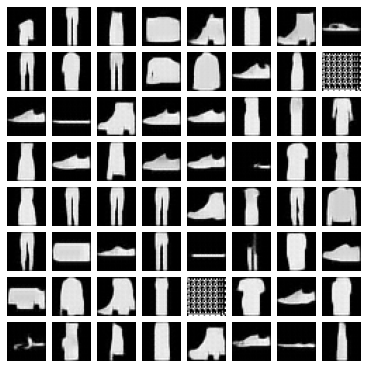

Epoch 45  Loss 1.701
Epoch 46  Loss 1.939
Epoch 47  Loss 1.848
Epoch 48  Loss 1.854
Epoch 49  Loss 1.775


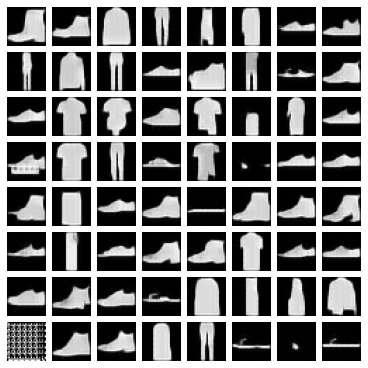

Epoch 50  Loss 1.729
Epoch 51  Loss 1.820
Epoch 52  Loss 1.743
Epoch 53  Loss 1.769
Epoch 54  Loss 1.862


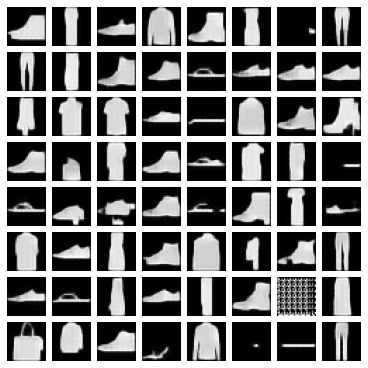

Epoch 55  Loss 1.855
Epoch 56  Loss 1.801
Epoch 57  Loss 1.721
Epoch 58  Loss 1.928
Epoch 59  Loss 1.850


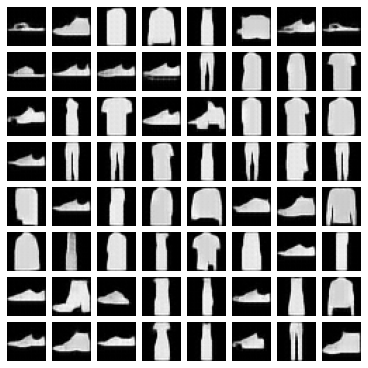

Epoch 60  Loss 1.678
Epoch 61  Loss 1.757
Epoch 62  Loss 1.809
Epoch 63  Loss 1.862
Epoch 64  Loss 1.813


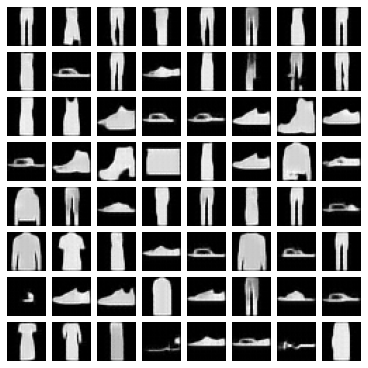

Epoch 65  Loss 1.782
Epoch 66  Loss 1.853
Epoch 67  Loss 1.918
Epoch 68  Loss 1.684
Epoch 69  Loss 1.796


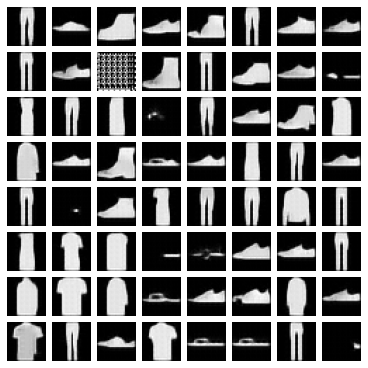

Epoch 70  Loss 1.885
Epoch 71  Loss 1.725
Epoch 72  Loss 1.758
Epoch 73  Loss 1.769
Epoch 74  Loss 1.603


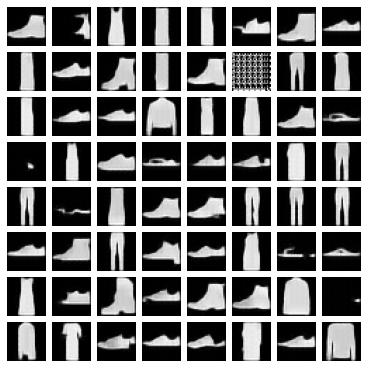

Epoch 75  Loss 1.778
Epoch 76  Loss 1.822
Epoch 77  Loss 1.768
Epoch 78  Loss 1.780
Epoch 79  Loss 1.686


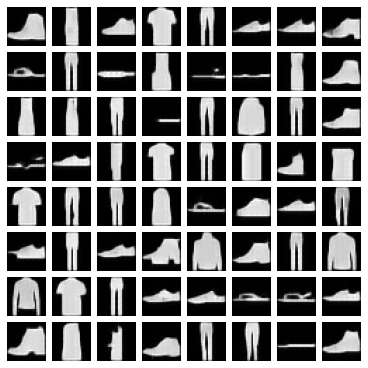

Epoch 80  Loss 1.601
Epoch 81  Loss 1.777
Epoch 82  Loss 1.638
Epoch 83  Loss 1.651
Epoch 84  Loss 1.775


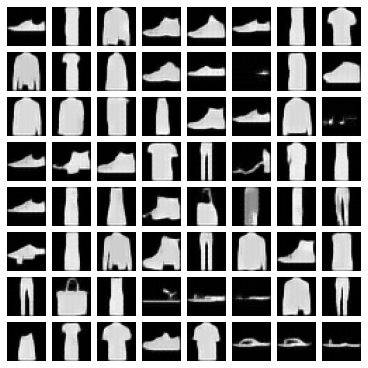

Epoch 85  Loss 1.837
Epoch 86  Loss 1.815
Epoch 87  Loss 1.802
Epoch 88  Loss 1.615
Epoch 89  Loss 1.798


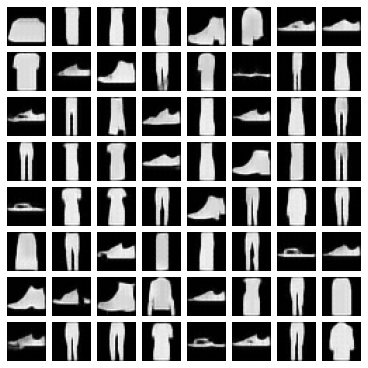

Epoch 90  Loss 1.727
Epoch 91  Loss 1.645
Epoch 92  Loss 1.667
Epoch 93  Loss 1.808
Epoch 94  Loss 1.554


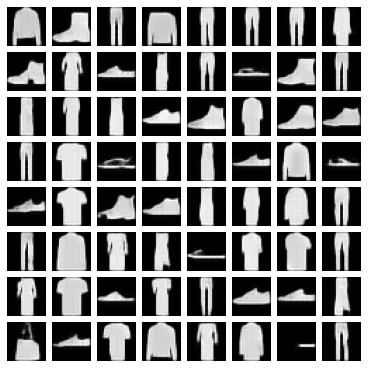

Epoch 95  Loss 1.711
Epoch 96  Loss 1.697
Epoch 97  Loss 1.761
Epoch 98  Loss 1.564
Epoch 99  Loss 1.671


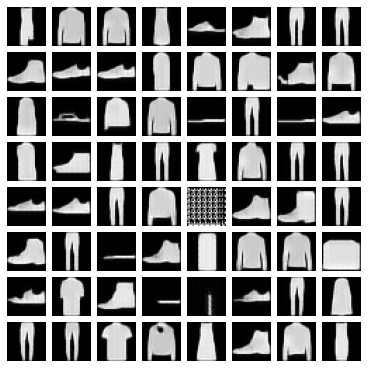

Epoch 100  Loss 1.700
Epoch 101  Loss 1.865
Epoch 102  Loss 1.619
Epoch 103  Loss 1.558
Epoch 104  Loss 1.583


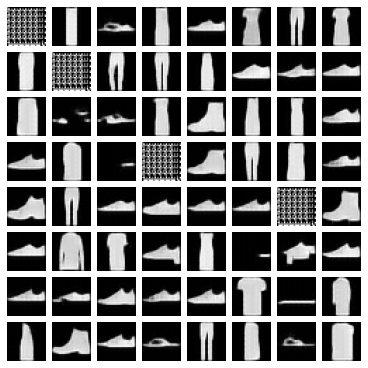

Epoch 105  Loss 1.611
Epoch 106  Loss 1.758
Epoch 107  Loss 1.723
Epoch 108  Loss 1.706
Epoch 109  Loss 1.732


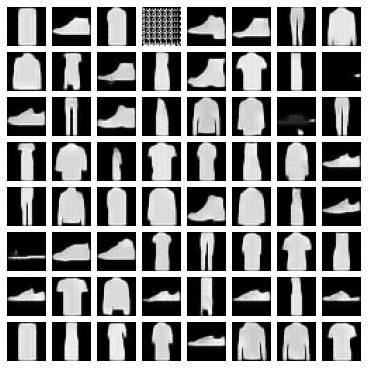

Epoch 110  Loss 1.819
Epoch 111  Loss 1.870
Epoch 112  Loss 1.633
Epoch 113  Loss 1.591
Epoch 114  Loss 1.711


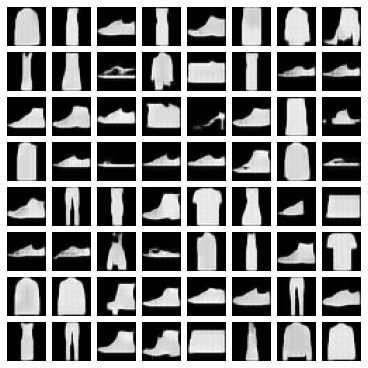

Epoch 115  Loss 1.616
Epoch 116  Loss 1.650
Epoch 117  Loss 1.601
Epoch 118  Loss 1.708
Epoch 119  Loss 1.756


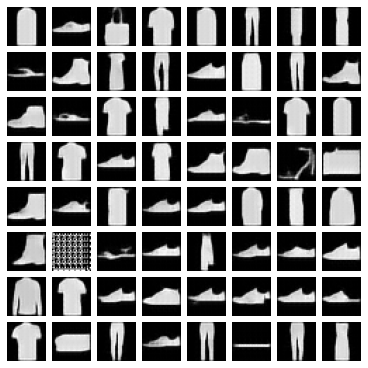

Epoch 120  Loss 1.609
Epoch 121  Loss 1.698
Epoch 122  Loss 1.661
Epoch 123  Loss 1.749
Epoch 124  Loss 1.693


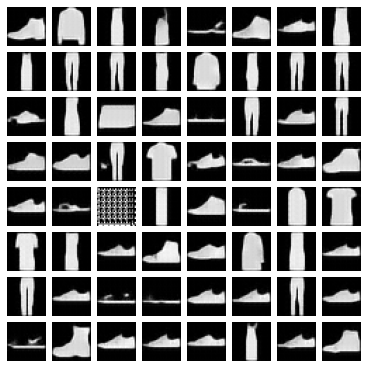

Epoch 125  Loss 1.475
Epoch 126  Loss 1.678
Epoch 127  Loss 1.684
Epoch 128  Loss 1.686
Epoch 129  Loss 1.596


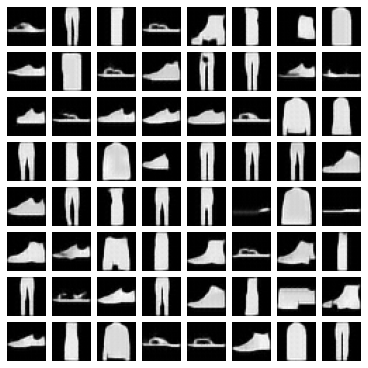

Epoch 130  Loss 1.521
Epoch 131  Loss 1.728
Epoch 132  Loss 1.785
Epoch 133  Loss 1.598
Epoch 134  Loss 1.661


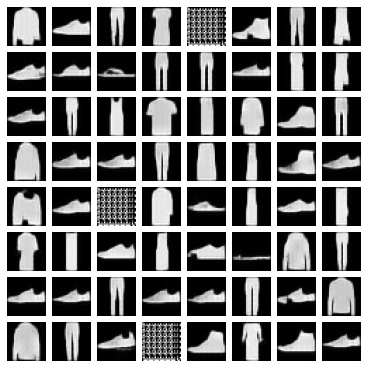

Epoch 135  Loss 1.836
Epoch 136  Loss 1.579
Epoch 137  Loss 1.592
Epoch 138  Loss 1.611
Epoch 139  Loss 1.603


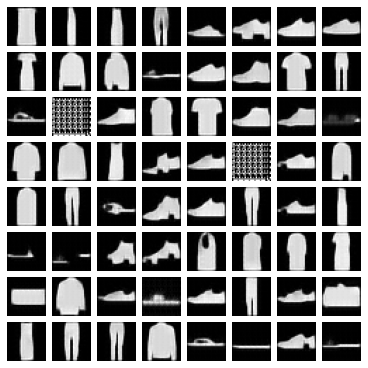

Epoch 140  Loss 1.701
Epoch 141  Loss 1.592
Epoch 142  Loss 1.605
Epoch 143  Loss 1.477
Epoch 144  Loss 1.785


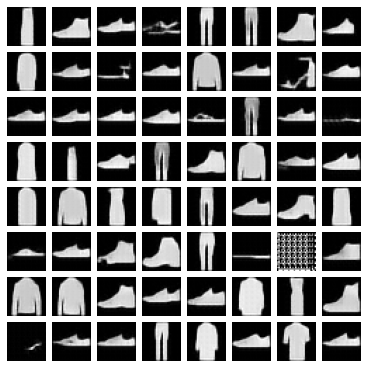

Epoch 145  Loss 1.614
Epoch 146  Loss 1.616
Epoch 147  Loss 1.794
Epoch 148  Loss 1.730


In [14]:
epochs = 500
optimizer = torch.optim.Adam(denoise_fn.parameters(), lr=1e-3)
plt_ = 1
for epoch in range(epochs):
    denoise_fn.train()
    for batch_idx, (indices) in enumerate(train_indices):
        indices = indices.float().cuda()
        indices = indices.unsqueeze(dim=1)
        loss = abdiff.train_iter(indices)
        loss = loss['loss']
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("Epoch {}  Loss {:.3f}".format(epoch, loss.item()))\
    
    if plt_ == 1 and (epoch+1)%5 == 0:
        denoise_fn.eval() 
        sample = (abdiff.sample(sample_steps=256)).reshape(64,7,7)
        with torch.inference_mode():
            z = model.vq_layer.quantize(sample.cuda())
            #print(z.shape)
            z = z.permute(0, 3, 1, 2).contiguous()
            #print(z.shape)
            # torch.Size([128, 16, 7, 7, 16])
            pred = model.decoder(z)

        generated_samples = np.array(np.clip((pred + 0.5).cpu().numpy(), 0., 1.) * 255, dtype=np.uint8)
        generated_samples = generated_samples.reshape(8, 8, 28, 28)

        fig = plt.figure(figsize=(5, 5), constrained_layout=True)
        gs = fig.add_gridspec(8, 8)
        for n_row in range(8):
            for n_col in range(8):
                f_ax = fig.add_subplot(gs[n_row, n_col])
                f_ax.imshow(generated_samples[n_row, n_col], cmap="gray")
                f_ax.axis("off")
        plt.show()
        